# Big project

## Submission

Submit solutions to https://forms.office.com/e/WexY7YraJb.

1.   Upload code in .ipynb file
2.   Upload a csv containing three columns: 
*    "ID": the ID of the instance (1, 2, 3, ...)
*    "OBJ": the objective function value obtained
*    "TIME": the execution time in seconds.

## Evaluation

1.   Gap w.r.t. optimal solutions
2.   Runtimes. Must be under 10 minutes for every instance. Execution times will be re-examined on a random basis.

## Deadline

12/01/2022 23:59 CET

## Other

*   4 lab points just if you deliver something that works
*   10 points based on the quality of method
*   NO pre-coded libraries, 
*   NO genetic algorithms 
*   NO neural networks
*   groups of max 3 students




## Biogas plants location

An association of $n$ farmers wants to open $p$ plants to produce energy from biogas. 
Each plant will be opened at a farm of a member of the association and will be powered with corn chopping purchased from the farm itself or from other neighboring farms.

Each farm $i$ can provide at most $c_i$ tons of corn chopping, with a percentage of dry matter $a_i$. As you may know, dry matter is the key component of corn chopping used for biogas production. In order to maintain the quality of produced energy, each plant must burn a mixture of corn chopping with a percentage of dry matter between $k_{min}$ and $k_{max}$. 

At most one plant can be located in each farm, and every farm can sell its corn chopping to one and only one plant.

Each farm $i$ is located at coordinates $x_i$ and $y_i$, representing respectively its latitude and longitude, and the cost of moving corn chopping from a farm $i$ to a farm $j$ is proportional to the euclidean distance between the two farms (it does not depend on the actual quantity moved, since the trucks used for this transportations are sufficiently big). 

Under such conditions, every plant produces $Q$ kWh of energy per ton of corn chopping burned. The energy produced by each plant will be fed into the national electricity system, at a unitary price of $b$ (€/kWh). Moreover, due to state regulations, each plant must not produce more than $M$ kWh of energy.

You must locate $p$ plants among the available farms and assign the farms that will supply each plant, with the goal of maximizing the total revenues of the association.

### Sets
*   $I$ = set of farms

### Parameters
*   $n$ = number of farms   
*   $p$ = number of plants to locate
*   $b$ = revenue per unit of energy (€/kWh)
*   $M$ = max energy production (kWh)
*   $Q$ = energy produced by a ton of corn chopping (kWh/t)
*   $k_{min} (k_{max})$ = min (max) percentage of dry matter for fermentation
*   $a_i$ = percentage of dry matter in chopping from farm $i \in I$
*   $c_i$ = tons of corn chopping available for each $i \in I$ (t)
*   $x_i, y_i$ = coordinates of farm $i \in I$

In [255]:
instance_id = 3;
baseUrl = "https://raw.githubusercontent.com/Daddeee/FOR_Labs_22-23/master/big-project";
istanceUrl = f'{baseUrl}/instances/instance_{instance_id}.json';
resultUrl = f'{baseUrl}/results/instance_{instance_id}.txt';
dataPath = "./data/"

!rm -rf {dataPath}
!wget {istanceUrl} -P {dataPath}
!wget {resultUrl} -P {dataPath}

--2022-12-21 11:44:18--  https://raw.githubusercontent.com/Daddeee/FOR_Labs_22-23/master/big-project/instances/instance_3.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1981 (1.9K) [text/plain]
Saving to: './data/instance_3.json'

instance_3.json     100%[===================>]   1.93K  --.-KB/s    in 0s      

2022-12-21 11:44:18 (4.81 MB/s) - './data/instance_3.json' saved [1981/1981]

--2022-12-21 11:44:18--  https://raw.githubusercontent.com/Daddeee/FOR_Labs_22-23/master/big-project/results/instance_3.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awai

### Import libraries

In [256]:
import numpy as np
import mip
import json
import networkx as nx
import matplotlib.pyplot as plt

### Compute distance
Inspired by: 
https://github.com/eth-cscs/PythonHPC/blob/master/numpy/03-euclidean-distance-matrix-numpy.ipynb

The "Euclidean Trick" math: 
https://www.robots.ox.ac.uk/~albanie/notes/Euclidean_distance_trick.pdf

In [257]:
def fast_distance_matrix(x):
    xy = x @ x.T
    x2 = xy.diagonal()[:,np.newaxis]
    return np.abs(x2 + x2.T - 2. * xy)**0.5

### Load instances

In [258]:
# Reads a .json instance and returns it in a dictionary
def load_instance(filename):
  with open(f'./data/{filename}', 'r') as f:
    data = json.load(f)
  return data

# Reads a .txt result and returns it
def load_result(filename):
  with open(f'./data/{filename}', 'r') as f:
      result = f.read()
  return float(result)

inst = load_instance(f'instance_{instance_id}.json')
inst_result = load_result(f'instance_{instance_id}.txt') if instance_id <= 4 else 1;

### Print result

In [259]:
treshold = 1e-7

def print_model(mode, figsize, font_size):
    m = model.m
    x = model.x
    y = model.y
    z = model.z
    I = model.I
    c = model.c
    
    obj = m.objective_value;
    gap = 100 * (obj - inst_result) / inst_result;
    print(f"Obj Func: {m.objective_value:.5f}, Gap: {gap:.5f} %")

    print("-----Farms-----")
    for i in I:
        if x[i].x > treshold:
            print(f"[--- {i:3d} x = {x[i].x:.3f} ---]")
            for j in I:
                if y[i][j].x > treshold:
                    print(f"{j} -(y = {y[i][j].x:.3f} z = {z[i][j].x:.2f} c = {c[j]:.3f})-> {i};")
    #Visualize solution on graph
    pos_c = {f'C{i}': (model.points[i][0], model.points[i][1]) for i in I}
    nodepos = {**pos_c}
    
    g = nx.Graph()
    g.add_nodes_from([f'C{i}' for i in I])
    edges = [(f'C{j}', f'C{i}') for j in I for i in I if y[i][j].x > treshold] 
    g.add_edges_from(edges)
    color = ['yellow' if x[i].x > treshold else 'cyan' for i in I]
    plt.figure(1, figsize=figsize)
    nx.draw_networkx(g, font_size=font_size, pos=nodepos, node_color=color)
    plt.show()    

### Solver

In [260]:
class Model:
    def __init__(self, instance):
        self.M = instance["M"]
        self.Q = instance["Q"]
        self.a = np.array(instance["a"])
        self.b = instance["b"]
        self.c = instance["c"]
        self.kmax = instance["kmax"]
        self.kmin = instance["kmin"]
        self.I = range(instance["n"])
        self.p = instance["p"]
        self.points = instance["points"]
        self.distances = fast_distance_matrix(np.array(self.points))

        self.m = mip.Model();
        self.setupVariables()
        self.setupConstraint()
                
        self.m.objective = mip.maximize(mip.xsum([self.z[i][j] * self.Q * self.b - self.y[i][j] * self.distances[i][j] for j in self.I for i in self.I]))
    
    def setupVariables(self):
        self.x = [self.m.add_var(lb= 0, ub=1) for i in self.I]
        self.y = [[self.m.add_var(lb=0, ub=1) for j in self.I] for i in self.I]
        self.z = [[self.m.add_var(lb = 0) for j in self.I] for i in self.I]

        

    def setupConstraint(self):
        #build p plants
        self.m.add_constr(mip.xsum([self.x[i] for i in self.I]) == self.p)
        
        #each farm can be assigned to at most one farm
        for j in self.I:
            self.m.add_constr(mip.xsum([self.y[i][j] for i in self.I]) <= 1)

        for i in self.I:
            for j in self.I:
                self.m.add_constr(self.y[i][j] <= self.x[i])

        #each farm can at most give c_i corn choppings, linking constraint
        for i in self.I:
            for j in self.I:
                self.m.add_constr(self.z[i][j] <= self.c[j] * self.y[i][j])

        # dry mattern percentage
        for i in self.I:
            chorn_choppings_aquired = mip.xsum([self.z[i][j] for j in self.I])
            self.m.add_constr(mip.xsum([self.z[i][j] * self.a[j] for j in self.I]) <= self.kmax * chorn_choppings_aquired)
            self.m.add_constr(mip.xsum([self.z[i][j] * self.a[j] for j in self.I]) >= self.kmin * chorn_choppings_aquired)

        # state regulations
        for i in self.I:
            self.m.add_constr(mip.xsum([self.z[i][j] for j in self.I]) * self.Q <= self.M)




In [261]:
def solve(inst) -> Model:
    model = Model(inst)
    model.m.verbose = 0;
    model.m.optimize();
    return model;




model = solve(inst)

Obj Func: 2358134.41610, Gap: 0.04529 %
-----Farms-----
[---   4 x = 0.794 ---]
1 -(y = 0.763 z = 1236.39 c = 1621.000)-> 4;
4 -(y = 0.794 z = 767.67 c = 967.000)-> 4;
12 -(y = 0.794 z = 1169.37 c = 1473.000)-> 4;
[---   6 x = 1.000 ---]
4 -(y = 0.206 z = 199.33 c = 967.000)-> 6;
6 -(y = 1.000 z = 1993.00 c = 1993.000)-> 6;
7 -(y = 0.307 z = 428.72 c = 1397.000)-> 6;
[---   7 x = 0.206 ---]
7 -(y = 0.206 z = 287.96 c = 1397.000)-> 7;
16 -(y = 0.205 z = 385.80 c = 1880.000)-> 7;
[---   8 x = 1.000 ---]
1 -(y = 0.237 z = 384.61 c = 1621.000)-> 8;
5 -(y = 1.000 z = 1559.00 c = 1559.000)-> 8;
7 -(y = 0.220 z = 307.51 c = 1397.000)-> 8;
8 -(y = 1.000 z = 418.00 c = 418.000)-> 8;
15 -(y = 1.000 z = 1586.00 c = 1586.000)-> 8;
[---  17 x = 1.000 ---]
12 -(y = 0.206 z = 303.63 c = 1473.000)-> 17;
14 -(y = 0.203 z = 176.66 c = 869.000)-> 17;
17 -(y = 1.000 z = 1144.00 c = 1144.000)-> 17;
[---  18 x = 1.000 ---]
3 -(y = 1.000 z = 864.00 c = 864.000)-> 18;
9 -(y = 1.000 z = 507.00 c = 507.000)-> 1

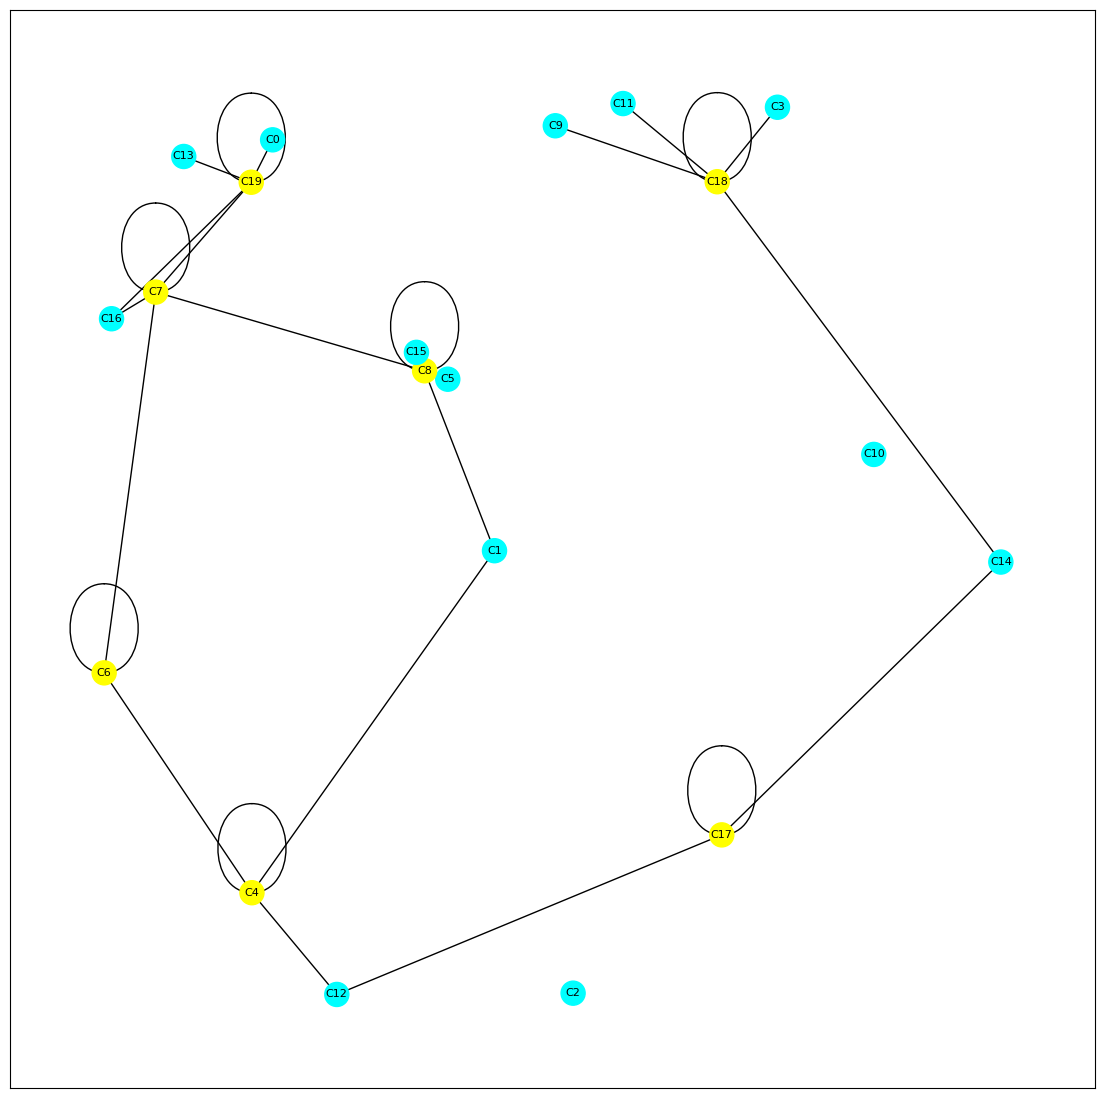

In [262]:
print_model(model, figsize=(14, 14), font_size=8);

def printVariableMatrix(var, label):
  print(f"\n{label}\n")
  for i in range(len(var)):
    print([f"{var[i][j].x:.5f}" for j in range(len(var[i]))])


def printVariableArray(var, label):
    print(f"\n{label}\n")
    print([f"{var[i].x:.5f}" for i in range(len(var))])


def printVarMatrixValue(var, i, j):
  print(f"{var[i][j].x:.5f}")









In [263]:
for i in model.I:
    if (i != 4):
        continue
    for j in model.I:
        if (model.z[i][j].x - model.y[i][j].x > treshold):
            print(f'z = {model.z[i][j].x:.3f} y = {model.y[i][j].x:.3f}')
            print(i, j)


printVariableArray(model.x, "X")
printVariableMatrix(model.y, "Y")
printVariableMatrix(model.y, "Z")



z = 1236.386 y = 0.763
4 1
z = 767.675 y = 0.794
4 4
z = 1169.375 y = 0.794
4 12

X

['-0.00000', '-0.00000', '-0.00000', '-0.00000', '0.79387', '-0.00000', '1.00000', '0.20613', '1.00000', '-0.00000', '-0.00000', '-0.00000', '-0.00000', '-0.00000', '-0.00000', '-0.00000', '0.00000', '1.00000', '1.00000', '1.00000']

Y

['-0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '-0.00000', '-0.00000', '0.00000', '0.00000', '-0.00000', '0.00000', '0.00000', '0.00000', '-0.00000', '0.00000', '0.00000', '0.00000', '0.00000']
['0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '-0.00000', '0.00000', '-0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '-0.00000', '0.00000']
['0.00000', '-0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '-0.00000', '0.00000', '-0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '-0.00000', '0.00000', '0.00000', '0.00000', '-0.00000', '0.00000']
['

In [264]:
eps = 1e-5

flag = True;
while True:
    model.m.optimize()
    obj = model.m.objective_value
    gap = 100 * (obj - inst_result) / inst_result

    print(f"Obj Func: {obj:.6f}, Gap: {gap:.6f}")

    pair = None  # Initialize pair to None, leave the loops
    n_min = 1;
    for i in model.I:
        for j in model.I:
            if model.y[i][j].x > eps and abs(model.y[i][j].x - 1) > eps and model.y[i][j].x - n_min < eps:
                n_min = model.y[i][j].x
                pair = (i, j)

    if pair == None:
        break  # No violated inequality was found, leave the loop

    i,j = pair

    model.m.add_constr(model.y[i][j] == 0)

    print(f"y[{i},{j}] = {model.y[i][j].x:.7f}", end=' | ')

print_model(model, figsize=(14, 14), font_size=8)